## Homework for KFU students

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as npl
import random

In [2]:
#Генерация данных
data_size = 100
x = np.linspace(0, 1, data_size)
y = 20 * np.sin(2 * np.pi * 3 * x) + 100 * np.exp(x)
x1 = np.linspace(1, 1.5, data_size)
e1 = 10 * np.random.randn(data_size)
e2 = 10 * np.random.randn(data_size)
y1 = y + e1
t1_true = np.zeros((data_size, 3))
t1_true[:,0]=1
y2 = y + e2 + 80
t2_true = np.zeros((data_size, 3))
t2_true[:,1]=1
t3_true = np.zeros((data_size, 3))
t3_true[:,2]=1
y3 = y + e1

In [3]:
# Соединяем наши выборки
res_x = np.hstack((x, x, x1))
res_y = np.hstack((y1, y2, y3))
all_data = np.vstack((res_x, res_y)).T

In [4]:
res_t = np.vstack((t1_true, t2_true, t3_true))
ind=list(range(len(all_data)))
np.random.shuffle(ind)  # Перемешиваем
trn_xx=all_data[ind]
res_t=res_t[ind]
new_res_t = []
for i in range(len(res_t)):
    if(res_t[i][0] == 1):
        new_res_t.append(0)
    elif(res_t[i][1] == 1):
        new_res_t.append(1)
    else:
         new_res_t.append(2)
res_t = np.array(new_res_t)

In [5]:
high_bord = 0.9
low_bord = 0.8
# Набор обучающих данных
trn_x = trn_xx[:int(low_bord * all_data.shape[0])]
trn_t = res_t[:int(low_bord * all_data.shape[0])]
# Набор валидационных данных
vld_x = trn_xx[int(low_bord * all_data.shape[0]):int(high_bord * all_data.shape[0])]
vld_t = res_t[int(low_bord * all_data.shape[0]):int(high_bord * all_data.shape[0])]
# Набор тестовых данных
tst_x = trn_xx[int(high_bord * all_data.shape[0]):]
tst_t = res_t[int(high_bord * all_data.shape[0]):]


In [6]:
from sklearn.linear_model import LogisticRegression
my_lambda = 1
my_gamma = 0.001

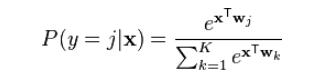

In [7]:
class MySoftmaxRegr(object):
    def __init__(self, eta=0.001, epochs=50,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):

        self.eta = eta
        self.epochs = epochs
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed

    def _fit(self, X, y, init_params=True):
        if init_params:
            if self.n_classes is None:
                self.n_classes = np.max(y) + 1
            self._n_features = X.shape[1]

            self.b_, self.w_ = self._init_params(
                weights_shape=(self._n_features, self.n_classes),
                bias_shape=(self.n_classes,),
                random_seed=self.random_seed)
            self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)

        for i in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):
                net = self._net_input(X[idx], self.w_, self.b_)
                softm = self._softmax(net)
                diff = softm - y_enc[idx]
                mse = np.mean(diff, axis=0)

                grad = np.dot(X[idx].T, diff)
                
                self.w_ -= (self.eta * grad )
                self.b_ -= (self.eta * np.sum(diff, axis=0))

            net = self._net_input(X, self.w_, self.b_)
            softm = self._softmax(net)
            cross_ent = self._cross_entropy(output=softm, y_target=y_enc)
            cost = self._cost(cross_ent)
            self.cost_.append(cost)
        return self

    def fit(self, X, y, init_params=True):
      
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        self._fit(X=X, y=y, init_params=init_params)
        self._is_fitted = True
        return self
    
    def _predict(self, X):
        probas = self.predict_proba(X)
        return self._to_classlabels(probas)
 
    def predict(self, X):
      
        if not self._is_fitted:
            raise AttributeError('Model is not fitted, yet.')
        return self._predict(X)

    def predict_proba(self, X):
       
        net = self._net_input(X, self.w_, self.b_)
        softm = self._softmax(net)
        return softm

    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def _cost(self, cross_entropy):
        return 0.5 * np.mean(cross_entropy)

    def _to_classlabels(self, z):
        return z.argmax(axis=1)
    
    def _init_params(self, weights_shape, bias_shape=(1,), dtype='float64',
                     scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        w = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
        b = np.zeros(shape=bias_shape)
        return b.astype(dtype), w.astype(dtype)
    
    def _one_hot(self, y, n_labels, dtype):
     
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)    
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = np.random.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1],
                                                indices[-remainder:]),
                                               axis=0)
                else:
                    minis = np.array_split(indices, n_batches)

            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch
    
    def _shuffle_arrays(self, arrays):
        """Shuffle arrays in unison."""
        r = np.random.permutation(len(arrays[0]))
        return [ary[r] for ary in arrays]

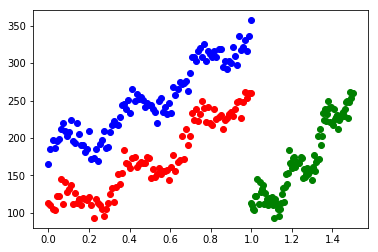

In [8]:
#Data visualization
plt.plot(all_data[:data_size, 0], all_data[:data_size,1], 'ro')
plt.plot(all_data[data_size:2*data_size, 0], all_data[data_size:2*data_size,1],'bo')
plt.plot(all_data[2*data_size:, 0], all_data[2*data_size:,1],'go')
plt.show()

c:\users\timkabor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in exp
c:\users\timkabor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
c:\users\timkabor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log
c:\users\timkabor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
c:\users\timkabor\appdata\local\programs\python\python37\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


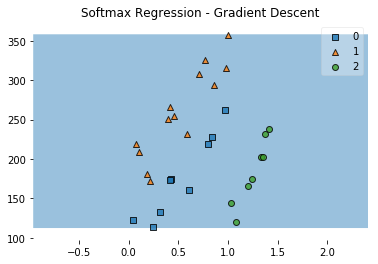

In [9]:
from mlxtend.plotting import plot_decision_regions

# Набор обучающих данных
trn_x = trn_xx[:int(low_bord * all_data.shape[0])]
trn_t = res_t[:int(low_bord * all_data.shape[0])]

# Набор тестовых данных
tst_x = trn_xx[int(high_bord * all_data.shape[0]):]
tst_t = res_t[int(high_bord * all_data.shape[0]):]


lr = MySoftmaxRegr(eta=0.01, epochs=10, minibatches=1, random_seed=0)
lr.fit(trn_x, trn_t)

plot_decision_regions(tst_x, tst_t, clf=lr)
plt.title('Softmax Regression - Gradient Descent')
plt.show()
